In [ ]:
import os, shutil
import json, sys

import numpy as np
import pandas as pd
import cudf
import cupy as cp
import datetime

from contextlib import contextmanager

from scipy.stats import randint, uniform

from tqdm import tqdm

import folium
from folium.plugins import MarkerCluster

import matplotlib.pyplot as plt
import matplotlib.colors as colors 
import matplotlib.cm as cm
import seaborn as sns
import plotly.express as px

from kmodes.kprototypes import KPrototypes

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.inspection import permutation_importance

from sklearn.ensemble import AdaBoostRegressor

import cuml
from cuml.ensemble import RandomForestRegressor
from cuml.neighbors import KNeighborsRegressor

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

In [14]:
base_dir = '/kaggle/input/mibici-de-guadalajara-from-2015-to-2023'

In [13]:
data = pd.DataFrame([])

# Load data
for t in os.listdir('data'):
    c1 = t.startswith('datos_abiertos_2018')
    c2 = t.startswith('datos_abiertos_2019')
    c3 = t.startswith('datos_abiertos_2022')
    c4 = t.startswith('datos_abiertos_2023')
    cond = c1 or c2 or c3 or c4 
    if cond:
        new = pd.read_csv('data/' + t, encoding='latin1')
        new.rename(columns={new.columns[3]: 'Año_de_nacimiento'}, inplace=True)
        data = pd.concat([data, new])

del new, c1, c2, c3, c4, cond, t
#eliminar filas con valores perdidos
data = data.dropna()

nomenclatura = pd.read_csv('data/nomenclatura_2023_02.csv', encoding='latin1')

data

,Viaje_Id,Usuario_Id,Genero,Año_de_nacimiento,Inicio_del_viaje,Fin_del_viaje,Origen_Id,Destino_Id
0,4783525,251562,M,1982.0,2018-01-01 06:01:03,2018-01-01 06:10:11,59,28
1,4783526,260233,M,2000.0,2018-01-01 06:03:15,2018-01-01 06:06:42,250,164
2,4783527,277431,M,1993.0,2018-01-01 06:09:56,2018-01-01 06:15:17,148,238
3,4783528,157371,M,1991.0,2018-01-01 06:16:50,2018-01-01 06:26:45,202,51
4,4783529,237066,M,1995.0,2018-01-01 06:19:44,2018-01-01 06:24:59,11,173
...,...,...,...,...,...,...,...,...
402455,28080048,2046454,F,1996.0,2023-03-31 23:57:47,2023-04-01 00:15:25,271,66
402456,28080049,2170004,M,2000.0,2023-03-31 23:57:53,2023-04-01 00:07:41,186,45
402457,28080050,2046041,M,2002.0,2023-03-31 23:58:15,2023-04-01 00:12:01,21,255
402458,28080051,252277,M,1998.0,2023-03-31 23:59:27,2023-04-01 00:04:44,175,172


In [14]:
data['Inicio_del_viaje'] = pd.to_datetime(data['Inicio_del_viaje'])
data['Fin_del_viaje'] = pd.to_datetime(data['Fin_del_viaje'])

# Calcular la duracion de cada viaje 
data['Duracion_del_viaje'] = data['Fin_del_viaje'] - data['Inicio_del_viaje']
data['Duracion_del_viaje'] = data['Duracion_del_viaje'].dt.total_seconds()/60

data['Duracion_del_viaje'] = data['Duracion_del_viaje'].apply(lambda x: float('{:.0f}.{:02.0f}'.format(*divmod(x * 60, 60))))

data['Año_de_nacimiento'] = data['Año_de_nacimiento'].astype(int)
data['Edad'] = data['Inicio_del_viaje'].dt.year.astype(int) - data['Año_de_nacimiento']

data = data.drop(['Año_de_nacimiento'], axis=1)

data = data[(data['Edad'] >= 15) & (data['Edad'] <= 80)]

data.dropna(axis=0, inplace=True)

data

,Viaje_Id,Usuario_Id,Genero,Inicio_del_viaje,Fin_del_viaje,Origen_Id,Destino_Id,Duracion_del_viaje,Edad
0,4783525,251562,M,2018-01-01 06:01:03,2018-01-01 06:10:11,59,28,9.08,36
1,4783526,260233,M,2018-01-01 06:03:15,2018-01-01 06:06:42,250,164,3.27,18
2,4783527,277431,M,2018-01-01 06:09:56,2018-01-01 06:15:17,148,238,5.21,25
3,4783528,157371,M,2018-01-01 06:16:50,2018-01-01 06:26:45,202,51,9.55,27
4,4783529,237066,M,2018-01-01 06:19:44,2018-01-01 06:24:59,11,173,5.15,23
...,...,...,...,...,...,...,...,...,...
402455,28080048,2046454,F,2023-03-31 23:57:47,2023-04-01 00:15:25,271,66,17.38,27
402456,28080049,2170004,M,2023-03-31 23:57:53,2023-04-01 00:07:41,186,45,9.48,23
402457,28080050,2046041,M,2023-03-31 23:58:15,2023-04-01 00:12:01,21,255,13.46,21
402458,28080051,252277,M,2023-03-31 23:59:27,2023-04-01 00:04:44,175,172,5.17,25


### Geolocalizacion de unidades

In [7]:
lat_center = np.mean(nomenclatura['latitude'])
long_center = np.mean(nomenclatura['longitude'])

### Localizacion de cada estacion

In [8]:
def plot_map(puntos, lat_center, long_center, zoom_start=12):

    # Crear un objeto de mapa centrado en la ciudad deseada
    mapa = folium.Map(location=[lat_center, long_center], zoom_start=zoom_start)

    # Agregar cada punto como un marcador al mapa
    for punto in puntos:
        latitud = punto['latitude']
        longitud = punto['longitude']
        nombre = punto['name']
        forma = folium.RegularPolygonMarker([latitud, longitud], popup=nombre, color='blue', fill_color='blue',
                                            number_of_sides=4, radius=4)
        forma.add_to(mapa)

    return mapa

conjunto_puntos = nomenclatura[['latitude', 'longitude', 'name']].to_dict('records')
plot_map(conjunto_puntos, lat_center, long_center)

### Numero de clientes que han pasado por cada estacion tanto de salida como de llegada

In [28]:
data_2018_19 = data[data['Inicio_del_viaje'].dt.year == 2018]
data_2018_19 = pd.concat([data_2018_19, data[data['Inicio_del_viaje'].dt.year == 2019]])

data_2022_23 = data[data['Inicio_del_viaje'].dt.year == 2022]
data_2022_23 = pd.concat([data_2022_23, data[data['Inicio_del_viaje'].dt.year == 2023]])

data_train = data_2022_23.sample(50000, replace=False)

In [17]:
# Calcular el numero de visitas por cada estacion
def num_visitas(data, nomenclatura):
    nomenclatura_merge = nomenclatura.copy() 
    nomenclatura_merge['num_visitas'] = 0

    for i in range(len(nomenclatura_merge)):
        nomenclatura_merge.loc[i, 'num_visitas'] = len(data[data['Origen_Id'] == nomenclatura.loc[i, 'id']])
        nomenclatura_merge.loc[i, 'num_visitas'] += len(data[data['Destino_Id'] == nomenclatura.loc[i, 'id']])
    
    return nomenclatura_merge

nomenclatura_2018_19 = num_visitas(data_2018_19, nomenclatura)
nomenclatura_2022_23 = num_visitas(data_2022_23, nomenclatura)

In [7]:
#contar cuantas estaciones tienen 0 visitas
print(len(nomenclatura_2018_19[nomenclatura_2018_19['num_visitas'] == 0]))
print(len(nomenclatura_2022_23[nomenclatura_2022_23['num_visitas'] == 0]))

34
12


In [15]:
def mapa_visitas(nomenclatura_merge, lat_center, long_center):    
    
    conjunto_puntos = nomenclatura_merge[['latitude', 'longitude', 'name', 'num_visitas']].to_dict('records')

    mapa = folium.Map(location=[lat_center, long_center], zoom_start=12)

    estaciones_sin_visitas = [punto for punto in conjunto_puntos if punto['num_visitas'] == 0]
    estaciones_con_visitas = [punto for punto in conjunto_puntos if punto['num_visitas'] > 0]

    min_visitas = min(punto['num_visitas'] for punto in conjunto_puntos)
    max_visitas = max(punto['num_visitas'] for punto in conjunto_puntos)

    for punto in estaciones_sin_visitas:
        latitud = punto['latitude']
        longitud = punto['longitude']
        nombre = punto['name']
        color = 'black'  
        
        folium.CircleMarker([latitud, longitud], radius=2, color=color, fill=True, fill_color=color,
                            fill_opacity=0.6, popup=nombre).add_to(mapa)

    colores = ['purple', 'orangered', 'darkorange' , 'gold', 'yellow']
    for punto in estaciones_con_visitas:
        latitud = punto['latitude']
        longitud = punto['longitude']
        nombre = punto['name']
        visitas = punto['num_visitas']
    
        if max_visitas == min_visitas:
            intensity = 1.0
        else:
            intensity = (visitas - min_visitas) / (max_visitas - min_visitas)

        color_index = int(intensity * (len(colores) - 1))
        color = colores[color_index]
        
        folium.CircleMarker([latitud, longitud], radius=2, color=color, fill=True, fill_color=color,
                            fill_opacity=0.6, popup=nombre).add_to(mapa)
        
    legend_html = '''
        <div style="position: fixed;
                    bottom: 50px; left: 50px; width: 200px; height: 200px;
                    z-index: 9999; font-size: 14px; background-color: white; border: 1px solid gray;
                    padding: 10px; overflow: hidden;">
            <div style="text-align: center; font-weight: bold; margin-bottom: 8px;">Legend</div>
            <div style="display: flex; flex-direction: column; align-items: flex-start;">
                <div style="display: flex; align-items: center; margin-bottom: 5px;">
                    <span style="background: black; border-radius: 50%; width: 10px; height: 10px; margin-right: 5px;"></span>
                    <span>No Visits</span>
                </div>
                <div style="display: flex; align-items: center; margin-bottom: 5px;">
                    <span style="background: purple; border-radius: 50%; width: 10px; height: 10px; margin-right: 5px;"></span>
                    <span>Low Visits</span>
                </div>
                <div style="display: flex; align-items: center; margin-bottom: 5px;">
                    <span style="background: orangered; border-radius: 50%; width: 10px; height: 10px; margin-right: 5px;"></span>
                    <span>Medium-Low Visits</span>
                </div>
                <div style="display: flex; align-items: center; margin-bottom: 5px;">
                    <span style="background: darkorange; border-radius: 50%; width: 10px; height: 10px; margin-right: 5px;"></span>
                    <span>Medium Visits</span>
                </div>
                <div style="display: flex; align-items: center; margin-bottom: 5px;">
                    <span style="background: gold; border-radius: 50%; width: 10px; height: 10px; margin-right: 5px;"></span>
                    <span>Medium-High Visits</span>
                </div>
                <div style="display: flex; align-items: center;">
                    <span style="background: yellow; border-radius: 50%; width: 10px; height: 10px; margin-right: 5px;"></span>
                    <span>High Visits</span>
                </div>
            </div>
        </div>
    '''

    # Agregar la leyenda al mapa como un objeto de tipo HTML
    mapa.get_root().html.add_child(folium.Element(legend_html))

    # Guardar el mapa como un archivo HTML
    return mapa

In [16]:
mapa_visitas(nomenclatura_2018_19, lat_center, long_center)

In [17]:
mapa_visitas(nomenclatura_2022_23, lat_center, long_center)

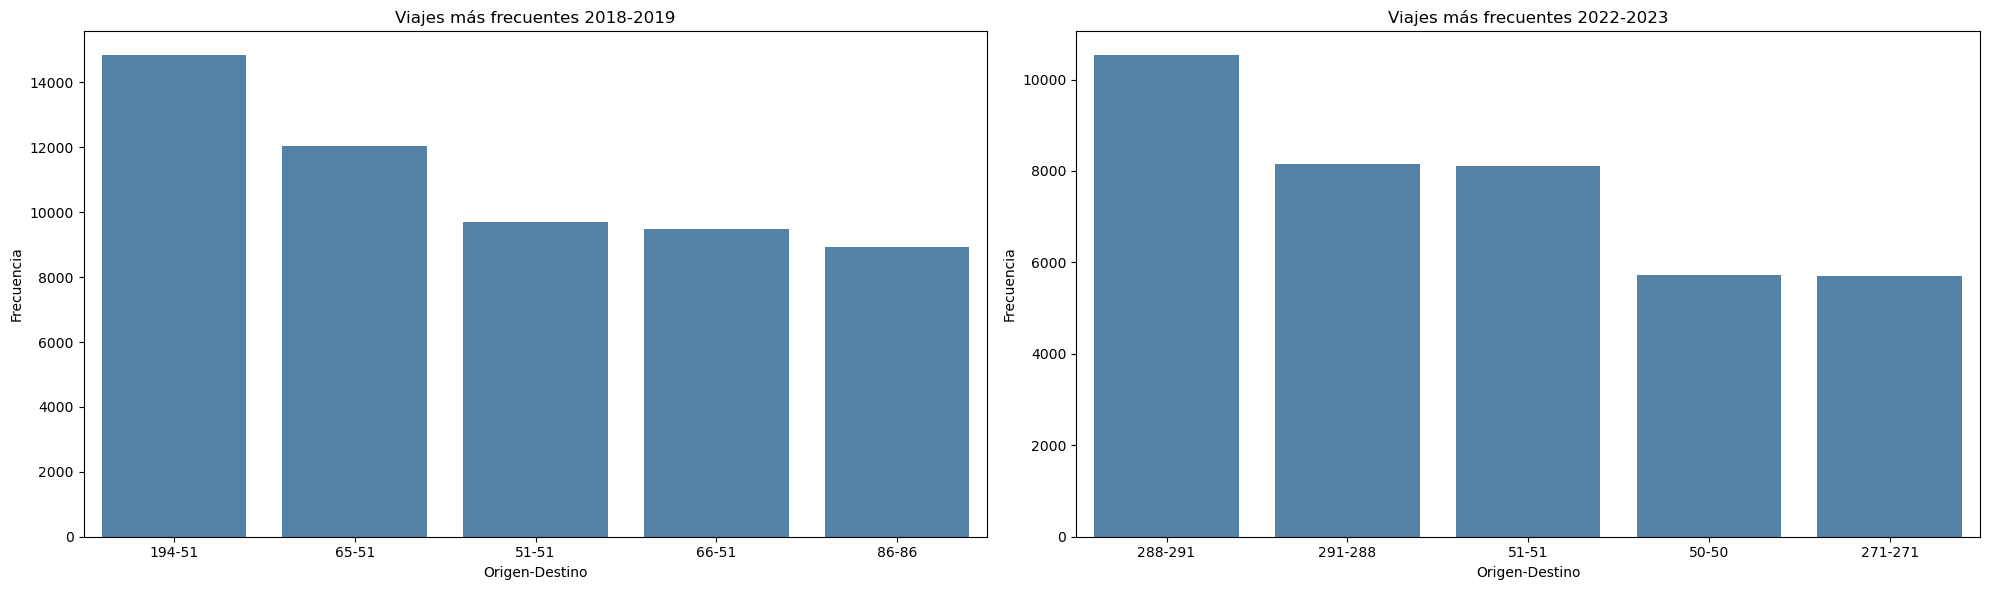

In [82]:
viajes_mas_frecuentes_18_19 = data_2018_19.groupby(['Origen_Id', 'Destino_Id']).size().reset_index(name='Frecuencia')
viajes_mas_frecuentes_18_19 = viajes_mas_frecuentes_18_19.sort_values(by='Frecuencia', ascending=False)
viajes_mas_frecuentes_22_23 = data_2022_23.groupby(['Origen_Id', 'Destino_Id']).size().reset_index(name='Frecuencia')
viajes_mas_frecuentes_22_23 = viajes_mas_frecuentes_22_23.sort_values(by='Frecuencia', ascending=False)

n = 5 
viajes_mas_frecuentes_18_19 = viajes_mas_frecuentes_18_19.head(n)
viajes_mas_frecuentes_18_19 = viajes_mas_frecuentes_18_19.assign(Origen_Destino=viajes_mas_frecuentes_18_19['Origen_Id'].astype(str)\
                                                                  + '-' + viajes_mas_frecuentes_18_19['Destino_Id'].astype(str))
viajes_mas_frecuentes_22_23 = viajes_mas_frecuentes_22_23.head(n)
viajes_mas_frecuentes_22_23 = viajes_mas_frecuentes_22_23.assign(Origen_Destino=viajes_mas_frecuentes_22_23['Origen_Id'].astype(str)\
                                                                    + '-' + viajes_mas_frecuentes_22_23['Destino_Id'].astype(str))

# Grafico de barra de los viajes más frecuentes
fig, ax= plt.subplots(1, 2, figsize=(20, 6))

sns.barplot(data=viajes_mas_frecuentes_18_19, y='Frecuencia', x='Origen_Destino', color='steelblue', ax=ax[0])
ax[0].set_xlabel('Origen-Destino')
ax[0].set_ylabel('Frecuencia')
ax[0].set_title('Viajes más frecuentes 2018-2019')

sns.barplot(data=viajes_mas_frecuentes_22_23, y='Frecuencia', x='Origen_Destino', color='steelblue', ax=ax[1])
ax[1].set_xlabel('Origen-Destino')
ax[1].set_ylabel('Frecuencia')
ax[1].set_title('Viajes más frecuentes 2022-2023')

plt.tight_layout()
plt.show()


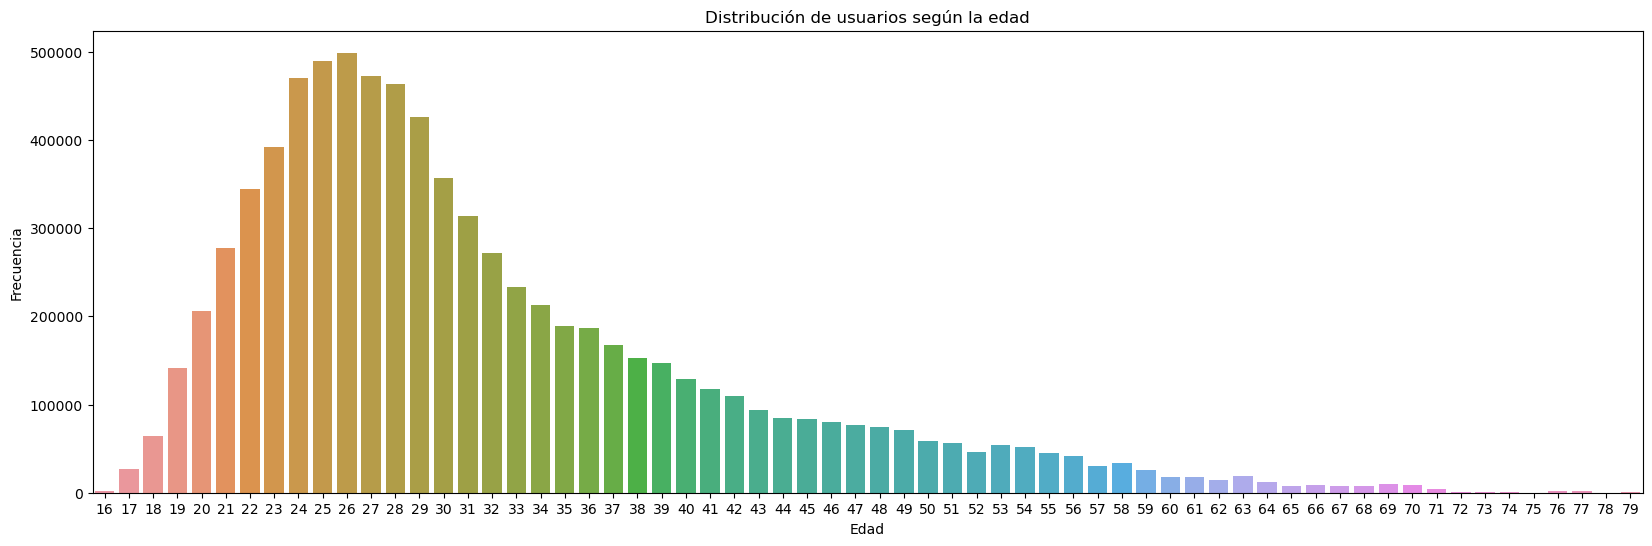

In [18]:
plt.figure(figsize=(20, 6))
sns.countplot(data=data_2018_19, x='Edad')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.title('Distribución de usuarios según la edad')
plt.show()

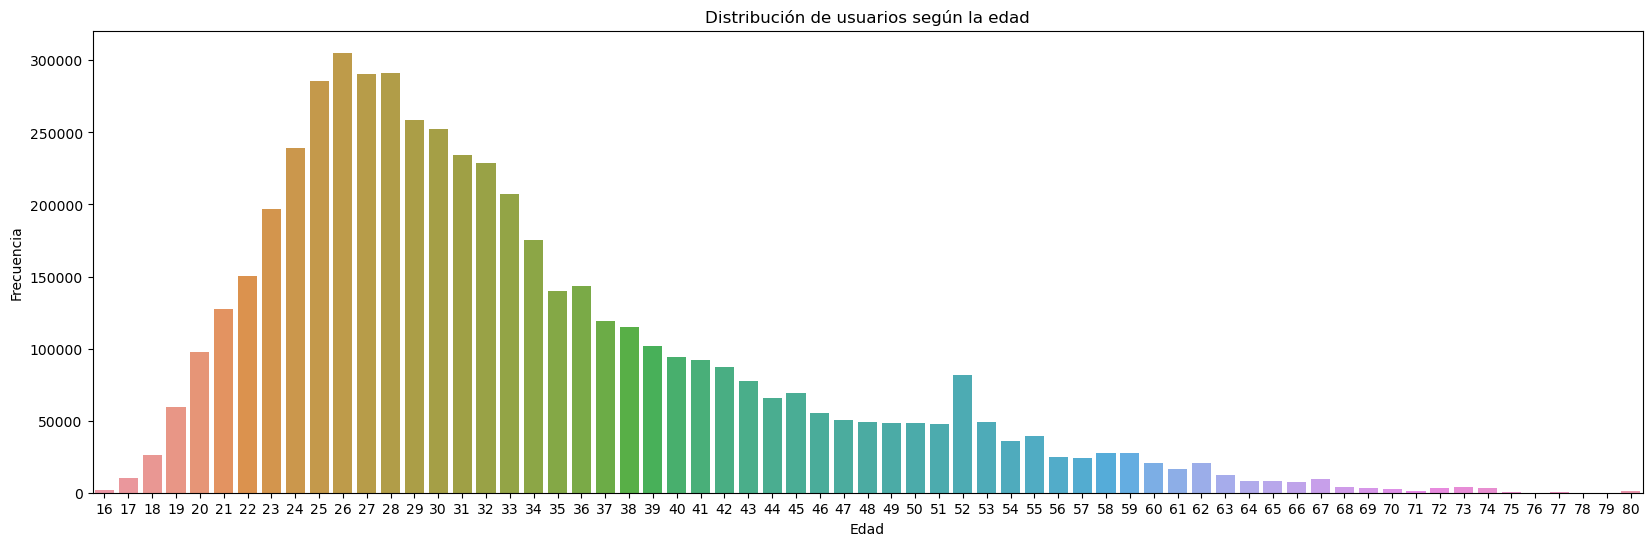

In [19]:
plt.figure(figsize=(20, 6))
sns.countplot(data=data_2022_23, x='Edad')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.title('Distribución de usuarios según la edad')
plt.show()

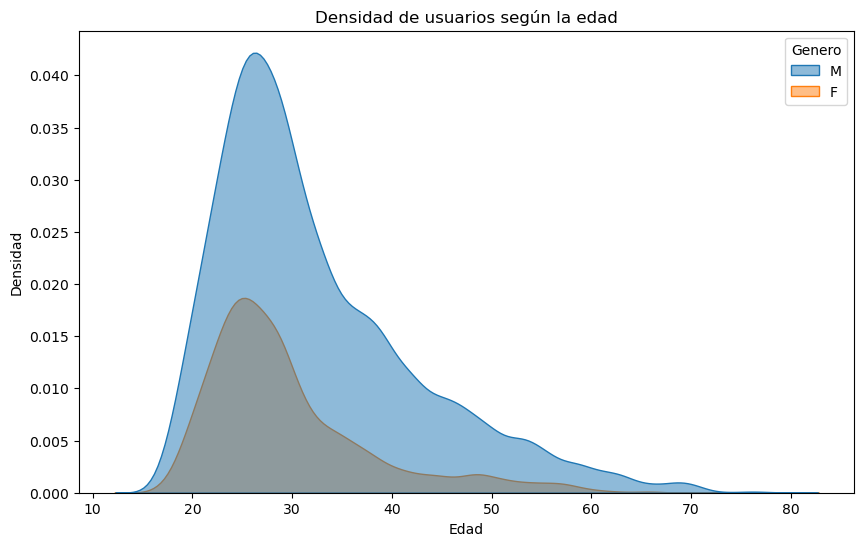

In [29]:
data_temp = data_2018_19.sample(50000, replace=False).reset_index(drop=True)

plt.figure(figsize=(10, 6))
sns.kdeplot(data=data_temp, x='Edad', hue='Genero', fill=True, alpha=0.5)
plt.xlabel('Edad')
plt.ylabel('Densidad')
plt.title('Densidad de usuarios según la edad')
plt.show()

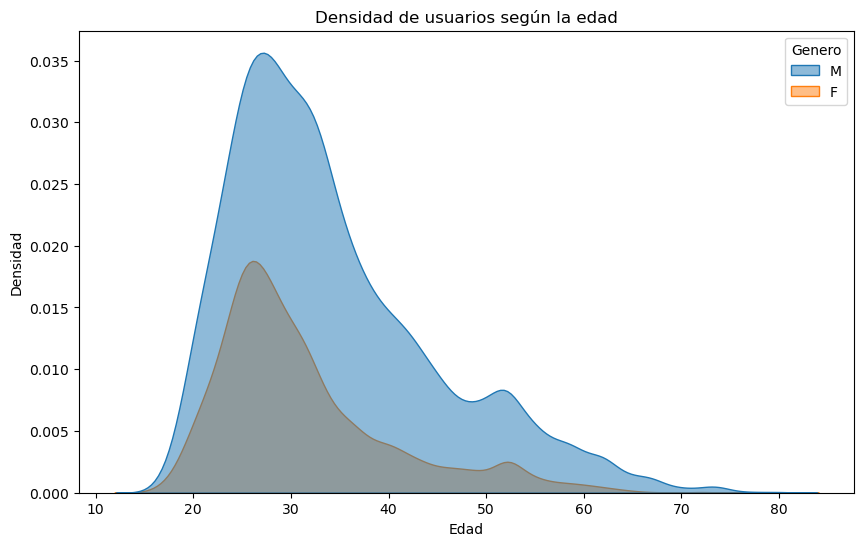

In [26]:
data_temp = data_train.reset_index(drop=True)

plt.figure(figsize=(10, 6))
sns.kdeplot(data=data_temp, x='Edad', hue='Genero', fill=True, alpha=0.5)
plt.xlabel('Edad')
plt.ylabel('Densidad')
plt.title('Densidad de usuarios según la edad')
plt.show()

del data_temp

### Clustering

In [6]:
del data_2018_19, data_2022_23, nomenclatura_2018_19, nomenclatura_2022_23

In [32]:
X = pd.DataFrame([])
X['mes_dia'] = data_train['Inicio_del_viaje'].dt.month + data_train['Inicio_del_viaje'].dt.day / 100
X['hora_salida'] = data_train['Inicio_del_viaje'].dt.hour + data_train['Inicio_del_viaje'].dt.minute / 100
X['hora_llegada'] = data_train['Fin_del_viaje'].dt.hour + data_train['Fin_del_viaje'].dt.minute / 100
X['Origen_Id'] = data_train['Origen_Id']
X['Destino_Id'] = data_train['Destino_Id']

X['genero'] = 0
X.loc[data_train['Genero'] == 'F', 'genero'] = 1

X['edad'] = data_train['Edad']

X['duracion_del_viaje'] = data_train['Duracion_del_viaje']

X

,mes_dia,hora_salida,hora_llegada,Origen_Id,Destino_Id,genero,edad,duracion_del_viaje
324206,2.26,19.14,19.25,52,272,1,31,10.55
355644,5.30,18.30,18.37,199,47,0,36,7.14
293660,10.24,18.27,18.27,185,185,0,33,0.23
88145,1.11,11.51,11.51,51,51,0,21,0.20
282478,6.24,18.58,19.02,144,150,0,26,3.36
...,...,...,...,...,...,...,...,...
171003,8.15,22.21,22.25,70,65,0,39,3.41
251113,8.22,20.24,20.40,195,51,0,28,15.22
324321,9.27,14.45,15.11,56,283,0,42,25.36
234272,5.20,7.28,7.28,256,256,1,21,0.21


In [21]:
def Plot2D(X, y, plot_name):
    
    fig = px.scatter(None, x = X[:,0], y = X[:,1], 
                     labels={
                         "x": "Dimension 1",
                         "y": "Dimension 2",
                     },
                     opacity=1, color=y)

    fig.update_layout(dict(plot_bgcolor = 'white'))

    fig.update_xaxes(showgrid = True, gridwidth = 1, gridcolor = 'lightgrey', 
                     zeroline = True, zerolinewidth = 1, zerolinecolor = 'lightgrey', 
                     showline = True, linewidth = 1, linecolor = 'black')

    fig.update_yaxes(showgrid = True, gridwidth = 1, gridcolor = 'lightgrey', 
                     zeroline = True, zerolinewidth = 1, zerolinecolor = 'lightgrey', 
                     showline = True, linewidth = 1, linecolor = 'black')

    fig.update_layout(title_text = plot_name)

    fig.update_traces(marker = dict(size = 5,
                        line = dict(color = 'black', width = 0.3)))
    
    return fig


def Plot3D(X, y, plot_name):
    fig = px.scatter_3d(None, 
                        x=X[:,0], y=X[:,1], z=X[:,2],
                        color=y,
                        height=800, width=800
                       )

    fig.update_layout(title_text=plot_name,
                      showlegend=False,
                      legend=dict(orientation="h", yanchor="top", y=0, xanchor="center", x=0.5),
                      scene_camera=dict(up=dict(x=0, y=0, z=1), 
                                            center=dict(x=0, y=0, z=-0.1),
                                            eye=dict(x=1.5, y=1.75, z=1)),
                                            margin=dict(l=0, r=0, b=0, t=0),
                      scene = dict(xaxis=dict(backgroundcolor='white',
                                              color='black',
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                             ),
                                   yaxis=dict(backgroundcolor='white',
                                              color='black',
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                              ),
                                   zaxis=dict(backgroundcolor='lightgrey',
                                              color='black', 
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                             )))
                                             
    fig.update_traces(marker=dict(size=3, 
                                  line=dict(color='black', width=0.1)))
    fig.update(layout_coloraxis_showscale=False)
    return fig

In [23]:
from sklearn.manifold import Isomap

def run_isomap(X, n_comp, num_neighbors):
    
    embed_isomap = Isomap(n_neighbors = num_neighbors, 
                          n_components = n_comp, 
                          n_jobs = 4)
    
    result = embed_isomap.fit_transform(X)
    
    return result

X_sample = X.sample(1000, random_state=42)

isomap2comp = run_isomap(X_sample, 2, 30)
isomap3comp = run_isomap(X_sample, 3, 30)

In [24]:
Plot2D(isomap2comp, range(len(isomap2comp)), 'Isomap de 2 dimensiones')

In [25]:
Plot3D(isomap3comp, range(len(isomap3comp)), 'Isomap de 3 dimensiones')

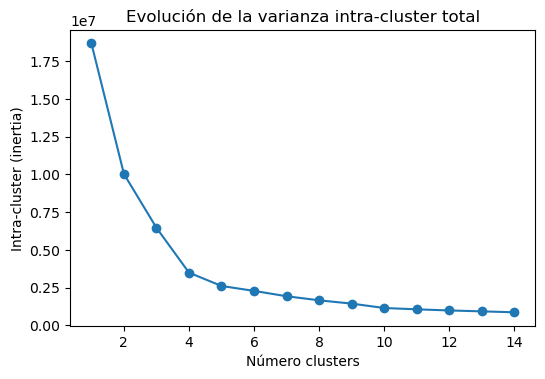

In [36]:
X_sample = X.sample(1000)

range_n_clusters = range(1, 15)
inertias = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
                        n_clusters   = n_clusters, 
                        n_init       = 'auto',
                        random_state = 123
                    )
    modelo_kmeans.fit(X_sample)
    inertias.append(modelo_kmeans.inertia_)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, inertias, marker='o')
ax.set_title("Evolución de la varianza intra-cluster total")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Intra-cluster (inertia)')
plt.show()

In [49]:
modelo_kmeans = KMeans(n_clusters = 4, init = 'auto', random_state = 0)
modelo_kmeans.fit_predict(X) 
modelo_kmeans.labels_

(49991,)

In [30]:
# Agregar la variable cluster a X
X['Cluster'] = modelo_kmeans.labels_

X_sample = X.sample(1000, random_state=42)
labels = X_sample['Cluster']
X_sample = X_sample.drop(['Cluster'], axis = 1)
X.drop(['Cluster'], axis = 1, inplace = True)

isomap2comp = run_isomap(X_sample, 2, 30)
isomap3comp = run_isomap(X_sample, 3, 30)

In [31]:
Plot2D(isomap2comp, labels, 'Isomap de 2 dimensiones')

In [32]:
Plot3D(isomap3comp, labels, 'Isomap de 2 dimensiones')

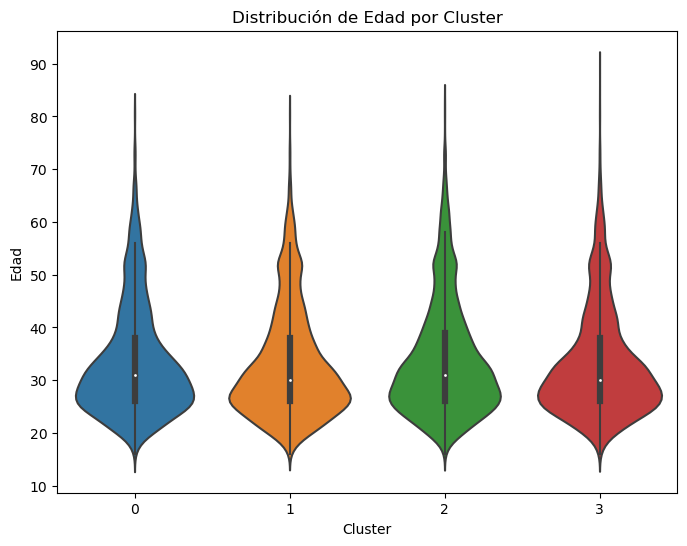

In [29]:
# Crear un DataFrame con las edades y los clusters
#data = pd.DataFrame({'Edad': X['edad'], 'Cluster': modelo_kproto.labels_})

data_violin = pd.DataFrame({'Edad': X['edad'], 'Cluster': modelo_kmeans.labels_})
# Graficar el violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(x='Cluster', y='Edad', data=data_violin)
plt.title('Distribución de Edad por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Edad')
plt.show()

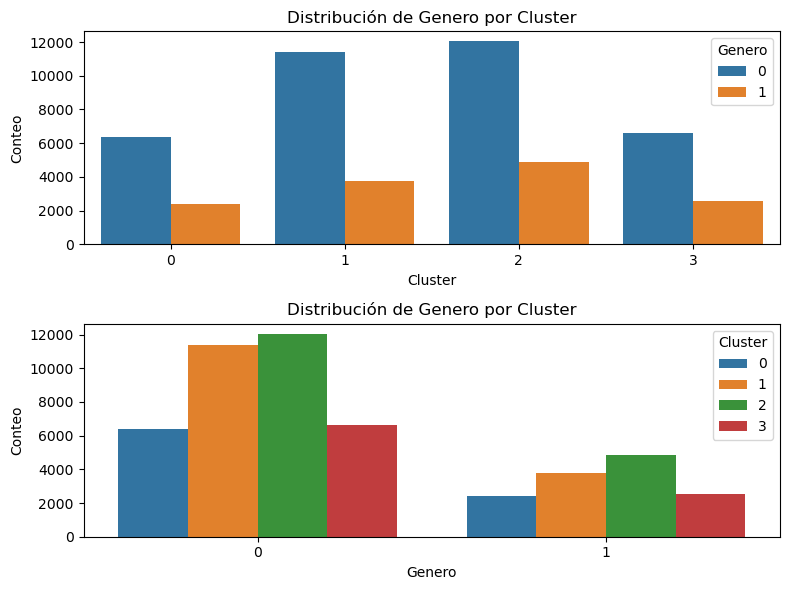

In [51]:
# Sacar dos graficas de barras con la distribucion de la variable genero en cada cluster

# Crear un DataFrame con las edades y los clusters
data_bar = pd.DataFrame({'Genero': X['genero'], 'Cluster': modelo_kmeans.labels_})

fig, ax = plt.subplots(2, 1, figsize=(8, 6))
sns.countplot(x='Cluster', hue='Genero', data=data_bar, ax=ax[0])
ax[0].set_title('Distribución de Genero por Cluster')
ax[0].set_xlabel('Cluster')
ax[0].set_ylabel('Conteo')

sns.countplot(x='Genero', hue='Cluster', data=data_bar, ax=ax[1])
ax[1].set_title('Distribución de Genero por Cluster')
ax[1].set_xlabel('Genero')
ax[1].set_ylabel('Conteo')

plt.tight_layout()
plt.show()


Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9
Cluster initiation: 10
Cluster initiation: 11
Cluster initiation: 12
Cluster initiation: 13
Cluster initiation: 14


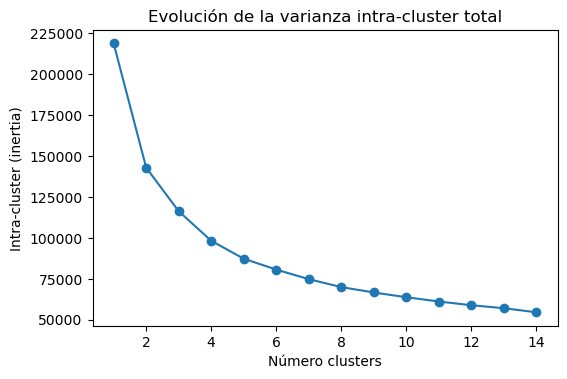

In [36]:
# Elbow method
X_temp = X.sample(1000)

columns = ['mes_dia', 'hora_salida', 'hora_llegada'	'Origen_Id', 'Destino_Id', 'genero', 'edad', 'duracion_del_viaje']
categorical_indices = [3, 4, 5]

range_n_clusters = range(1, 15)
inertias = []

cost = []
for cluster in range_n_clusters:
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
        kprototype.fit_predict(X_temp, categorical = categorical_indices)
        inertias.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, inertias, marker='o')
ax.set_title("Evolución de la varianza intra-cluster total")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Intra-cluster (inertia)')
plt.show()

del X_temp

In [37]:
modelo_kproto = KPrototypes(n_jobs = -1, n_clusters = 2, init = 'Huang', random_state = 0)
modelo_kproto.fit_predict(X, categorical = categorical_indices) 
modelo_kproto.labels_

array([0, 0, 0, ..., 1, 0, 0], dtype=uint16)

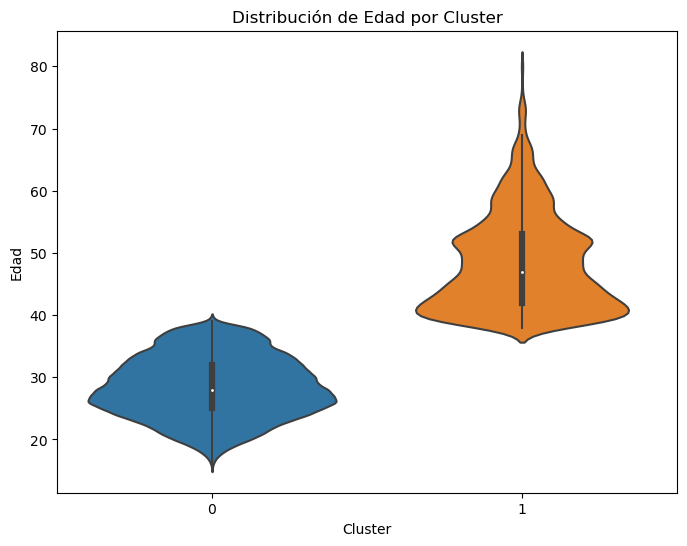

In [38]:
# Crear un DataFrame con las edades y los clusters
data_violin = pd.DataFrame({'Edad': X['edad'], 'Cluster': modelo_kproto.labels_})

# Graficar el violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(x='Cluster', y='Edad', data=data_violin)
plt.title('Distribución de Edad por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Edad')
plt.show()

In [49]:
data_temp = X.copy()
data_temp['Cluster'] = modelo_kproto.labels_

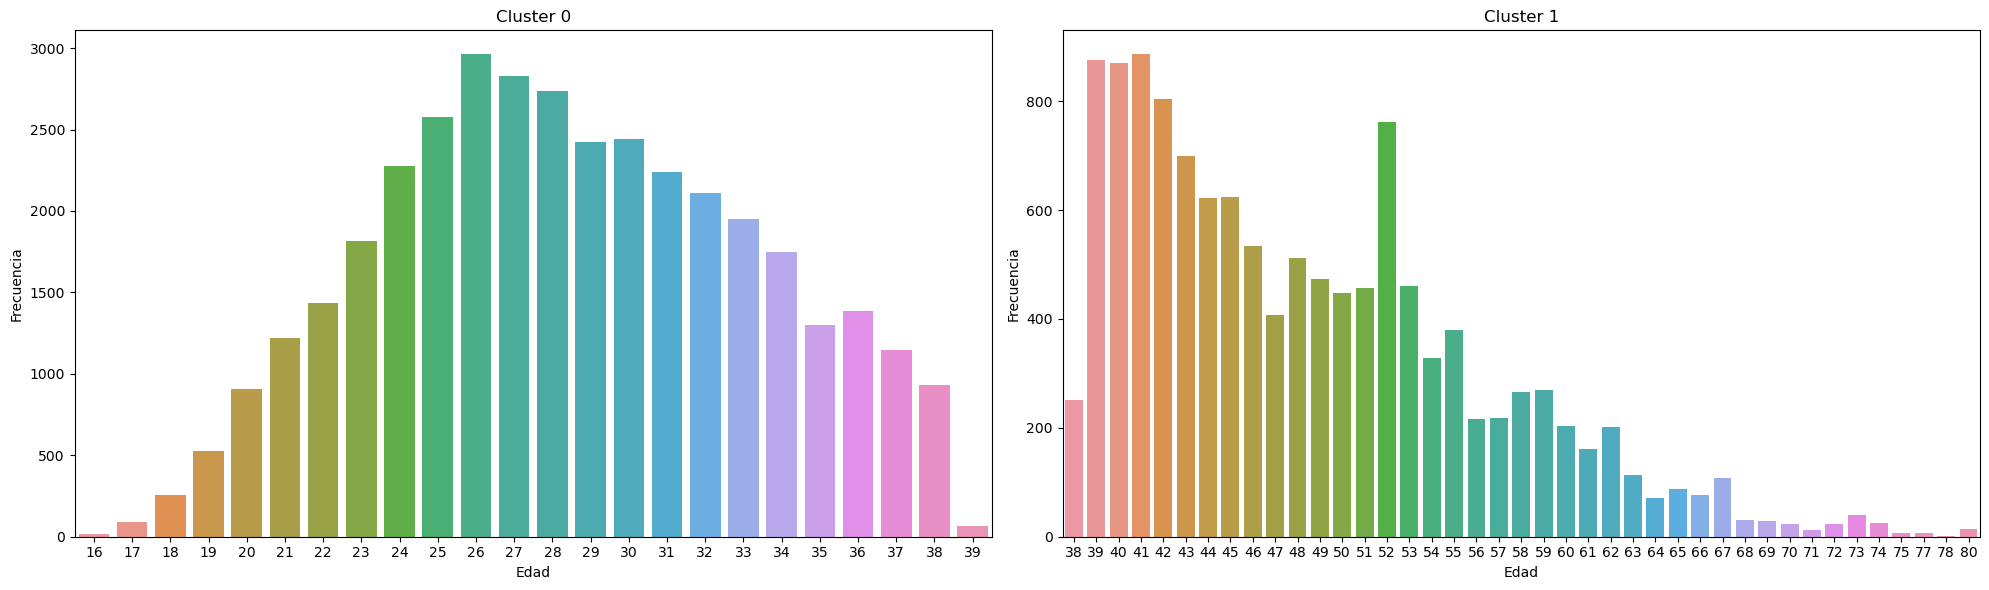

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

sns.countplot(data=data_temp[data_temp['Cluster'] == 0], x='edad', ax=ax[0])
ax[0].set_xlabel('Edad')
ax[0].set_ylabel('Frecuencia')
ax[0].set_title('Cluster 0')

sns.countplot(data=data_temp[data_temp['Cluster'] == 1], x='edad', ax=ax[1])
ax[1].set_xlabel('Edad')
ax[1].set_ylabel('Frecuencia')
ax[1].set_title('Cluster 1')

plt.tight_layout()
plt.show()

# Predicciones del tiempo de viaje 

In [22]:
X = pd.DataFrame([])
X['mes'] = data_train['Inicio_del_viaje'].dt.month + data_train['Inicio_del_viaje'].dt.day / 100
X['hora'] = data_train['Inicio_del_viaje'].dt.hour + data_train['Inicio_del_viaje'].dt.minute / 60
X['Origen_Id'] = data_train['Origen_Id']
X['Destino_Id'] = data_train['Destino_Id']
X['edad'] = 0.0

X['y'] = data_train['Duracion_del_viaje']

mask_2022 = data_train['Inicio_del_viaje'].dt.year == 2022
mask_2023 = ~mask_2022

X.loc[mask_2022, 'edad'] = 2022.0 - data_train.loc[mask_2022, 'Año_de_nacimiento']
X.loc[mask_2023, 'edad'] = 2023.0 - data_train.loc[mask_2023, 'Año_de_nacimiento']
X = X[(X['edad'] >= 15) & (X['edad'] <= 100)]

X.dropna(axis=0, inplace=True)
#X = cudf.DataFrame.from_pandas(X)
X_grid = X.sample(10000)
X_grid

,mes,hora,Origen_Id,Destino_Id,edad,y
355775,11.29,10.783333,4,49,26.0,7.966667
77716,5.07,8.616667,151,267,36.0,7.550000
37249,3.03,14.883333,65,85,31.0,5.733333
216457,8.19,16.516667,20,263,24.0,31.533333
186949,7.17,22.650000,148,270,27.0,9.333333
...,...,...,...,...,...,...
235001,9.20,14.516667,66,64,20.0,3.733333
97289,9.08,14.700000,165,249,20.0,5.350000
4311,7.01,12.583333,178,273,29.0,11.300000
74883,1.08,19.250000,13,63,27.0,12.083333


In [18]:
#X_train, X_test, y_train, y_test = cuml.model_selection.train_test_split(
X_train, X_test, y_train, y_test = train_test_split(
    X_grid.drop('y', axis=1), X_grid['y'],
    random_state=123,
    test_size=0.2
)

X_train_true, X_test_true, y_train_true, y_test_true = train_test_split(
    X.drop('y', axis=1), X['y'],
    random_state=123,
    test_size=0.2
)

# Random Forest

In [19]:
param_grid = {
    'n_estimators': np.arange(180, 250, 20),
    'max_depth': [10, 15, 20],
    'min_samples_split': [10, 20, 50],
    'min_samples_leaf': [4, 8, 16]
}

grid = GridSearchCV(
        estimator  = cuml.ensemble.RandomForestRegressor(random_state=123),
        param_grid = param_grid, 
        scoring    = 'neg_root_mean_squared_error',
        cv         = 3, 
        refit      = True,
        verbose    = 1,
        return_train_score = False
       )

grid.fit(X = X_train, y = y_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_test_score,std_test_score
91,20,8,20,240,-7.113706,0.047575
90,20,8,20,220,-7.114257,0.049463
55,15,8,20,240,-7.114409,0.048123
54,15,8,20,220,-7.114889,0.049807


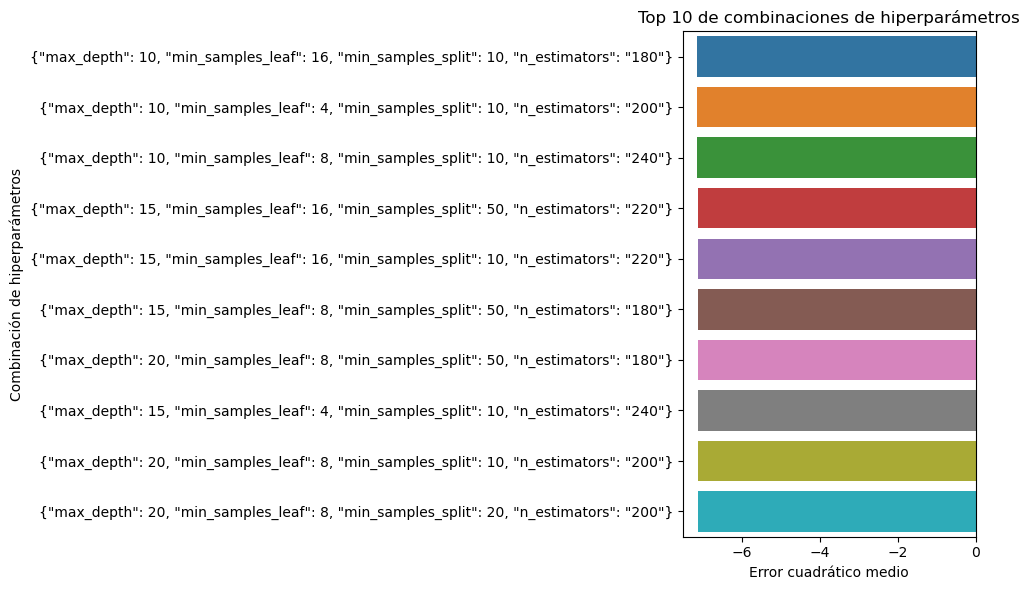

In [36]:
quantiles = np.linspace(0, 1, num=11)
quantile_labels = pd.qcut(resultados['mean_test_score'], q=quantiles, labels=False, duplicates='drop')

# Agregar las etiquetas al DataFrame de resultados
resultados['quantile_labels'] = quantile_labels

# Agrupar los resultados por las etiquetas de los quantiles
resultados_grouped = resultados.groupby('quantile_labels').apply(lambda x: x.sample(n=1)).reset_index(drop=True)
resultados_grouped['params_str'] = resultados_grouped['params'].apply(lambda x: json.dumps(x, default=str))

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar las barras
sns.barplot(data=resultados_grouped,
            x='mean_test_score',
            y='params_str',
            ax=ax)

ax.set_title('Top 10 de combinaciones de hiperparámetros')
ax.set_xlabel('Error cuadrático medio')
ax.set_ylabel('Combinación de hiperparámetros')
plt.tight_layout()
plt.show()

In [24]:
param = {
    'n_estimators': 240,
    'max_depth': 20,
    'min_samples_split': 20,
    'min_samples_leaf': 8
}

rf = cuml.ensemble.RandomForestRegressor(n_estimators=param['n_estimators'],
                               max_depth=param['max_depth'],
                               min_samples_split=param['min_samples_split'],
                               min_samples_leaf=param['min_samples_leaf'],
                               random_state=123)

rf.fit(X_train_true, y_train_true)

y_pred = rf.predict(X_test_true)

print('RMSE: ', np.sqrt(mean_squared_error(y_test_true, y_pred)))

6.952481887118552


# AdaBoost

In [28]:
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

# Definir los parámetros para buscar con RandomizedSearchCV
params = {
    'n_estimators': randint(100, 300),
    'learning_rate': uniform(0.001, 0.1),
    'base_estimator__n_neighbors': randint(1, 30),
}

# Realizar la búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(estimator          = AdaBoostRegressor(estimator=cuml.neighbors.KNeighborsRegressor()), 
                                   param_distributions = params,
                                   n_iter             = 50, 
                                   scoring            = 'neg_root_mean_squared_error',
                                   cv                 = 3,
                                   refit              = True,
                                   verbose            = 0,
                                   return_train_score = False,
                                  )

with suppress_stdout():
    random_search.fit(X_train, y_train)
    
# Resultados
# ==============================================================================

resultados = pd.DataFrame(random_search.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_base_estimator__n_neighbors,param_learning_rate,param_n_estimators,mean_test_score,std_test_score
0,16,0.003952,171,-8.815064,1.108293
21,7,0.005331,225,-9.689069,1.156412
37,14,0.021301,100,-10.128043,1.520408
38,29,0.022233,111,-10.292735,1.176343


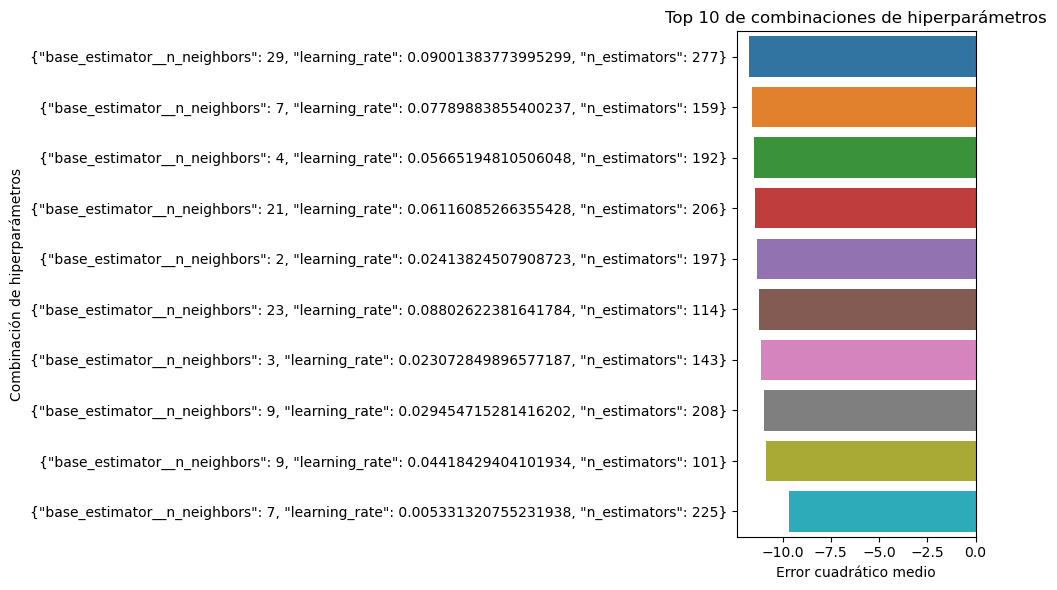

In [42]:
quantiles = np.linspace(0, 1, num=11)
quantile_labels = pd.qcut(resultados['mean_test_score'], q=quantiles, labels=False, duplicates='drop')

# Agregar las etiquetas al DataFrame de resultados
resultados['quantile_labels'] = quantile_labels

# Agrupar los resultados por las etiquetas de los quantiles
resultados_grouped = resultados.groupby('quantile_labels').apply(lambda x: x.sample(n=1)).reset_index(drop=True)
resultados_grouped['params_str'] = resultados_grouped['params'].apply(lambda x: json.dumps(x, default=str))

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar las barras
sns.barplot(data=resultados_grouped,
            x='mean_test_score',
            y='params_str',
            ax=ax)

ax.set_title('Top 10 de combinaciones de hiperparámetros')
ax.set_xlabel('Error cuadrático medio')
ax.set_ylabel('Combinación de hiperparámetros')
plt.tight_layout()
plt.show()

In [29]:
params = {
    'n_estimators': 171,
    'learning_rate': 0.003952,
    'base_estimator__n_neighbors': 16,
}

adaboost = AdaBoostRegressor(estimator = cuml.neighbors.KNeighborsRegressor(n_neighbors = params['base_estimator__n_neighbors']),
                  n_estimators = params['n_estimators'],
                  learning_rate = params['learning_rate'])

with suppress_stdout():
    adaboost.fit(X_train_true, y_train_true)

y_pred = adaboost.predict(X_test_true)

print('RMSE: ', np.sqrt(mean_squared_error(y_test_true, y_pred)))

RMSE:  7.472471881448535


# Perceptron Multicapa

In [61]:
model_dir = '/kaggle/working/model_saved'
os.mkdir(model_dir)

In [62]:
mlp = Sequential()
mlp.add(Dense(64, input_dim=5, activation='relu'))
mlp.add(Dense(32, activation='relu'))
mlp.add(Dense(1, activation='linear'))

rmse = keras.metrics.RootMeanSquaredError(
    name='rmse', dtype=None
)
mlp.compile(loss = 'mse', optimizer='rmsprop', metrics=[rmse])


model_dir_per_epoc = os.path.join(model_dir, 'weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5')
checpoint = ModelCheckpoint(model_dir_per_epoc, 
                            monitor='val_loss', 
                            save_best_only=False,
                            verbose=0)

calbacks = [checpoint]

history = mlp.fit(X_train_true, y_train_true, 
          epochs=20, 
          batch_size=120, 
          verbose=1,
          validation_split=0.2,
          callbacks = calbacks)

Epoch 1/20
2658/2658 [==============================] - 14s 5ms/step - loss: 76.4024 - rmse: 8.7408 - val_loss: 65.5524 - val_rmse: 8.0964
Epoch 2/20
2658/2658 [==============================] - 12s 4ms/step - loss: 72.3147 - rmse: 8.5038 - val_loss: 65.0833 - val_rmse: 8.0674
Epoch 3/20
2658/2658 [==============================] - 13s 5ms/step - loss: 71.2381 - rmse: 8.4403 - val_loss: 62.6828 - val_rmse: 7.9172
Epoch 4/20
2658/2658 [==============================] - 12s 5ms/step - loss: 70.5541 - rmse: 8.3996 - val_loss: 62.6177 - val_rmse: 7.9131
Epoch 5/20
2658/2658 [==============================] - 12s 5ms/step - loss: 70.2362 - rmse: 8.3807 - val_loss: 63.5743 - val_rmse: 7.9733
Epoch 6/20
2658/2658 [==============================] - 13s 5ms/step - loss: 70.0468 - rmse: 8.3694 - val_loss: 63.7947 - val_rmse: 7.9872
Epoch 7/20
2658/2658 [==============================] - 13s 5ms/step - loss: 69.8679 - rmse: 8.3587 - val_loss: 62.9913 - val_rmse: 7.9367
Epoch 8/20
2658/2658 [=====

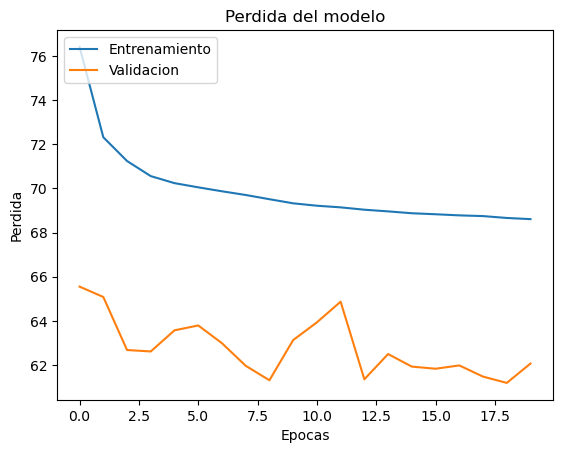

In [63]:
plt.plot(mlp.history.history['loss'])
plt.plot(mlp.history.history['val_loss'])
plt.title('Perdida del modelo')
plt.ylabel('Perdida')
plt.xlabel('Epocas')
plt.legend(['Entrenamiento', 'Validacion'], loc='upper left')
plt.show()

In [66]:
models_dir = os.path.join(model_dir, os.listdir(model_dir)[-1])
model = keras.models.load_model(models_dir)

y_pred = model.predict(X_test_true)

print('RMSE: ', np.sqrt(mean_squared_error(y_test_true, y_pred)))

3114/3114 [==============================] - 6s 2ms/step
RMSE:  7.766881273691078


# Importancia de los predictores

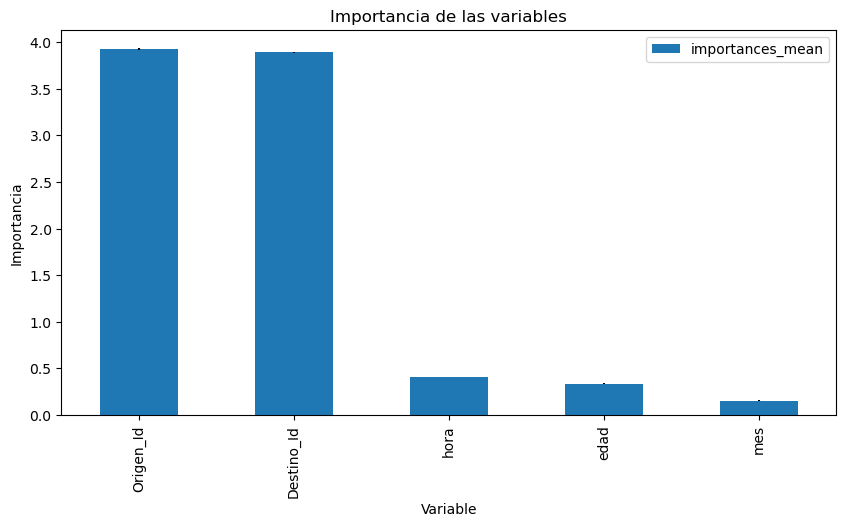

,importances_mean,importances_std,feature
2,3.929711,0.007502,Origen_Id
3,3.894584,0.005533,Destino_Id
1,0.406918,0.001487,hora
4,0.334338,0.008451,edad
0,0.153576,0.003911,mes


In [19]:
importancia = permutation_importance(
                estimator    = rf,
                X            = X.drop('y', axis=1),
                y            = X['y'],
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importancia['feature'] = X.drop('y', axis=1).columns

fig, ax = plt.subplots(figsize=(10, 5))
df_importancia.sort_values('importances_mean', ascending=False).plot.bar(x='feature', y='importances_mean', yerr='importances_std', ax=ax)
ax.set_title('Importancia de las variables')
ax.set_ylabel('Importancia')
ax.set_xlabel('Variable')
plt.show()

df_importancia.sort_values('importances_mean', ascending=False)